In [81]:
# Jupyter notebook for regression models (Gradient Boosting, Random Forest Regression)
# CSC691 Final Project
# PaceMakers: Predicting Average Heart Rate for Bike Rides
# Patrick, Esteban, Sarah
# 12/2/19

In [1]:
import pandas as pd

In [99]:
# Please update the path to the activities.csv file from the repository
df = pd.read_csv('activities.csv')
df_new = pd.read_csv('new_activities.csv')

In [100]:
df.head()

,Date,Name,Type,Moving Time,Distance (km),Elevation Gain (m),Avg Moving Speed (kph),Avg Pace (/km),Calories,Best 20min Speed (kph),Best 20min Pace (/km),Running Stress Score,Running Stress Score / h,Avg HR (bpm),HRSS,HRSS / h,Best 20min HR (bpm),Cadence Avg Moving (rpm or spm),Avg Watts (w),Avg Watts / Kilograms (w/kg),Best 20min Power (w),Power Stress Score,Power Stress Score / h,Athlete Settings,Delete
0,2019-09-22T16:27:01-04:00,Último día de verano,Ride,01:58:06,62.5,589.0,31.7,01:53,1772,34,01:45,-,-,158,144,73,163,95,179,2.56,201,-,0,MaxHr 190bpm. RestHr 65bpm. Weight 70kg.,NaN
1,2019-09-21T11:57:23-04:00,Dos loops,Ride,02:38:51,80.1,890.0,28.7,02:05,2432,36.7,01:38,-,-,158,217,77,173,89,174,2.49,225,-,0,MaxHr 190bpm. RestHr 65bpm. Weight 70kg.,NaN
2,2019-09-20T17:55:47-04:00,Con poco tiempo,Ride,01:07:52,35.2,314.0,30.9,01:56,1029,34.5,01:44,-,-,159,87,76,163,91,169,2.42,188,-,0,MaxHr 190bpm. RestHr 65bpm. Weight 70kg.,NaN
3,2019-09-19T23:45:00-04:00,Complimentary calisthenics,Workout,01:00:00,0.0,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Weight 70kg.,NaN
4,2019-09-18T17:41:48-04:00,Afternoon Ride,Ride,01:26:05,45.6,447.0,31.4,01:54,1326,36,01:40,-,-,161,119,81,173,97,181,2.59,221,-,0,MaxHr 190bpm. RestHr 65bpm. Weight 70kg.,NaN


In [101]:
# Before feature pre-processing
df.describe()

,Distance (km),Elevation Gain (m),Delete
count,573.000000,573.000000,0.0
mean,35.888656,620.718325,NaN
std,29.855291,601.756726,NaN
min,0.000000,0.000000,NaN
25%,9.300000,189.400000,NaN
50%,32.900000,526.000000,NaN
75%,51.900000,884.600000,NaN
max,170.600000,3617.000000,NaN


### Feature Preprocessing

In [102]:
# Select features and rename columns
df = df[['Avg HR (bpm)','Date','Type','Distance (km)','Avg Pace (/km)','Calories','HRSS','Elevation Gain (m)']]
df = df.rename(columns={"Avg HR (bpm)": "AvgHR"})
df_new = df_new[['Avg HR (bpm)','Date','Type','Distance (km)','Avg Pace (/km)','Calories','HRSS','Elevation Gain (m)']]
df_new = df_new.rename(columns={"Avg HR (bpm)": "AvgHR"})
df.head()

,AvgHR,Date,Type,Distance (km),Avg Pace (/km),Calories,HRSS,Elevation Gain (m)
0,158,2019-09-22T16:27:01-04:00,Ride,62.5,01:53,1772,144,589.0
1,158,2019-09-21T11:57:23-04:00,Ride,80.1,02:05,2432,217,890.0
2,159,2019-09-20T17:55:47-04:00,Ride,35.2,01:56,1029,87,314.0
3,-,2019-09-19T23:45:00-04:00,Workout,0.0,-,-,-,0.0
4,161,2019-09-18T17:41:48-04:00,Ride,45.6,01:54,1326,119,447.0


In [103]:
# Define features and pre-process data for final dataset
from dateutil.parser import parse

# Filter rows to include only those with AvgHR
df = df[df.AvgHR != '-']
df_new = df_new[df_new.AvgHR != '-']

# Only include Ride and VirtualRide types
types = ['Ride', 'VirtualRide']
df = df[df.Type.isin(types)]
df_new = df_new[df_new.Type.isin(types)]
df = df.reset_index(drop=True)
df_new = df_new.reset_index(drop=True)

# Convert features to numbers
df["AvgHR"] = pd.to_numeric(df["AvgHR"])
df["Calories"] = pd.to_numeric(df["Calories"])
df["HRSS"] = pd.to_numeric(df["HRSS"])
df_new["AvgHR"] = pd.to_numeric(df["AvgHR"])
df_new["Calories"] = pd.to_numeric(df["Calories"])
df_new["HRSS"] = pd.to_numeric(df["HRSS"])
df.head()

# Convert Avg Pace to seconds, parse Date and Time as separate columns
for i in range(df.shape[0]):
    (m, s) = str(df.loc[i,'Avg Pace (/km)']).split(':')
    df.loc[i,'Avg Pace (/km)']= (int(m) * 60) + int(s)
    dt = parse(df.loc[i,'Date'])
    df.loc[i,'Date'] = dt.date()
    df.loc[i,'Time'] = dt.time()

# Convert Avg Pace to number
df['Avg Pace (/km)'] = pd.to_numeric(df['Avg Pace (/km)'])
df_new['Avg Pace (/km)'] = pd.to_numeric(df['Avg Pace (/km)'])


df_new.head()

,AvgHR,Date,Type,Distance (km),Avg Pace (/km),Calories,HRSS,Elevation Gain (m)
0,158,2019-12-01T13:17:10-05:00,VirtualRide,43.3,113,1772,144,355.0
1,158,2019-11-30T14:30:19-05:00,VirtualRide,46.3,125,2432,217,292.0
2,159,2019-11-29T12:45:50-05:00,Ride,105.4,116,1029,87,1074.0
3,161,2019-11-28T14:00:21-05:00,Ride,45.1,114,1326,119,465.0
4,155,2019-11-27T20:27:18-05:00,VirtualRide,53.1,120,1156,96,490.0


In [104]:
df.groupby(['Type']).mean()

,AvgHR,Distance (km),Avg Pace (/km),Calories,HRSS,Elevation Gain (m)
Type,,,,,,
Ride,154.535593,53.271525,152.298305,1615.294915,155.122034,912.209831
VirtualRide,165.500000,30.450000,115.357143,691.142857,86.714286,394.757143


In [105]:
df.groupby(['Type']).describe()

AvgHR                                                       \
             count        mean        std    min     25%    50%     75%   
Type                                                                      
Ride         295.0  154.535593  12.103490   84.0  149.00  155.0  160.50   
VirtualRide   14.0  165.500000  16.383622  135.0  156.75  163.0  175.75   

                   Distance (km)                                           \
               max         count       mean        std  min    25%    50%   
Type                                                                        
Ride         191.0         295.0  53.271525  27.276345  1.4  33.25  50.40   
VirtualRide  191.0          14.0  30.450000   7.812785  8.1  28.40  30.15   

                          Avg Pace (/km)                                      \
               75%    max          count        mean       std   min     25%   
Type                                                                           
Ride         61.15  170.6          295.0  152.298305  42.64518  86.0  119.50   
VirtualRide  34.60   41.1           14.0  115.357143  14.15631  98.0  104.75   

                                 Calories                                  \
               50%    75%    max    count         mean         std    min   
Type                                                                        
Ride         152.0  169.0  477.0    295.0  1615.294915  844.898853   48.0   
VirtualRide  110.5  123.0  146.0     14.0   691.142857  126.781373  475.0   

                                               HRSS                         \
                 25%     50%     75%     max  count        mean        std   
Type                                                                         
Ride         1012.00  1395.0  1873.0  5415.0  295.0  155.122034  82.494477   
VirtualRide   644.25   678.5   727.0  1016.0   14.0   86.714286  25.968705   

                                             Elevation Gain (m)              \
              min   25%    50%    75%    max              count        mean   
Type                                                                          
Ride          3.0  99.5  134.0  189.5  471.0              295.0  912.209831   
VirtualRide  43.0  75.0   91.5   94.0  127.0               14.0  394.757143   

                                                               
                    std    min    25%    50%      75%     max  
Type                                                           
Ride         656.472151    0.0  512.0  743.0  1131.85  3617.0  
VirtualRide  114.192663  230.6  301.0  368.5   500.00   558.0

In [110]:
# Create binary labels for High 'AvgHR' (1) and Low 'AvgHR' (0) based on threshold of 154 bpm
for j in range(df.shape[0]):
    if int(df.loc[j,'AvgHR']) > 154:
        #print(df.loc[j,'AvgHR'])
        df.loc[j,'AvgHR_bin'] = 1
    else: 
        df.loc[j,'AvgHR_bin'] = 0
for m in range(df_new.shape[0]):
    if int(df_new.loc[m,'AvgHR']) > 154:
        #print(df.loc[j,'AvgHR'])
        df_new.loc[m,'AvgHR_bin'] = 1
    else: 
        df_new.loc[m,'AvgHR_bin'] = 0

In [113]:
df.groupby('AvgHR_bin').mean()

,AvgHR,Distance (km),Avg Pace (/km),Calories,HRSS,Elevation Gain (m)
AvgHR_bin,,,,,,
0.0,145.794521,55.214384,167.794521,1644.650685,145.445205,1048.490411
1.0,163.306748,49.571166,135.245399,1509.625767,157.914110,745.698773


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


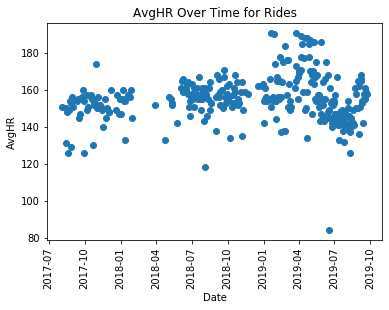

In [12]:
# Plot AvgHR over time for all virtual and outdoor bike rides
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot_date(df['Date'],df['AvgHR'])
plt.title('AvgHR Over Time for Rides')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('AvgHR')
plt.show()

In [13]:
# Calculate sample size of each class
count_no_sub = len(df[df['AvgHR_bin']==1])
count_sub = len(df[df['AvgHR_bin']==0])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of High AvgHR is", '%.2f' %(pct_of_no_sub*100))
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of Low AvgHR is", '%.2f' %(pct_of_sub*100))

percentage of High AvgHR is 52.75
percentage of Low AvgHR is 47.25


Text(0, 0.5, 'Frequency of Average HR')

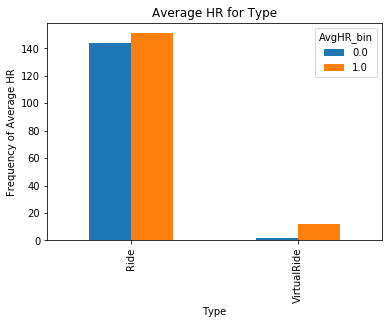

In [14]:
# Plot distribution of AvgHR for Rides and VirtualRides
import matplotlib.pyplot as plt
%matplotlib inline
pd.crosstab(df.Type,df.AvgHR_bin).plot(kind='bar')
plt.title('Average HR for Type')
plt.xlabel('Type')
plt.ylabel('Frequency of Average HR')
#plt.savefig('purchase_avghr_type')

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [21]:
# Define train and test set, perform RFE
window_size = 10
# removed Calories as feature since p-value was 0.07 > 0.05 (from below Logit function), as recommended
df_vars = ['Distance (km)', 'Avg Pace (/km)', 'HRSS', 'Elevation Gain (m)','AvgHR']
df_final = df[df_vars]
df_final_vars=df_final.columns.values.tolist()
y=df_final.AvgHR
X=[i for i in df_final_vars if i not in y]

X = df_final.loc[:, df_final.columns != 'AvgHR']
y = df_final.loc[:, df_final.columns == 'AvgHR']

# Configure train and test sets
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]

X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
print(X_test, y_test)

# Perform RFE (recursive feature elimination) to determine ranking of features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

   Distance (km)  Avg Pace (/km)  HRSS  Elevation Gain (m)
0           62.5             113   144               589.0
1           80.1             125   217               890.0
2           35.2             116    87               314.0
3           45.6             114   119               447.0
4           41.1             120    96               454.0
5           61.4             122   146               692.0
6           81.0             129   225              1096.0
7           51.4             128    90               576.0
8           55.4             114   116               502.0
9           47.2             116   106               447.0    AvgHR
0    158
1    158
2    159
3    161
4    155
5    155
6    158
7    142
8    153
9    154
[ True  True  True  True]
[1 1 1 1]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Gradient Boosting

### Implement Gradient Boosting with LOO and window size = 299

In [52]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

window_size = 10
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
# train set
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]
print('train labels: ', y_train)
# test set
X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
print('test labels: ', y_test)

actuals = pd.DataFrame(y_test)
actuals = actuals.rename(columns={'AvgHR':'Actuals'})
# print('actuals: \n', actuals)
preds = np.zeros(X_test.shape[0])
# print('X_test: \n', X_test)

for i in range(0,y_test.shape[0]):
    print('Iteration: ', i)
    print('X train shape: ', X_train.shape[0])
    print('X test shape: ', y_test.shape[0])
    # Fit model
    clf.fit(X_train, y_train.values.ravel())
    # Predict test set
    y_pred = clf.predict(np.array(X_test.iloc[-1]).reshape(1,-1))
    # Compute mean squared error
    mse = mean_squared_error(y_test.iloc[-1], y_pred)
    print('actual: ',y_test.iloc[-1], '\n pred: ',y_pred, '\n')
    preds[i] = y_pred
    print('mse: ', mse)
    # print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
    #print('test instance: ', X_test.iloc[-1])
    # X_train = pd.concat([X_test.iloc[0], X_train]).reset_index(drop = True)
    # print('new X train: ', X_train.head())
    
    # Perform LOO cross-validation
    #print("X test -1: ", X_test.iloc[-1])
    X_test_inst = pd.DataFrame(data= [X_test.iloc[-1]],columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
    y_test_inst = pd.DataFrame(data = [y_test.iloc[-1]],columns=["AvgHR"])
    #print("X test inst: ", X_test_inst)
    X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
    X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
    #print("X train: \n", X_train)

    y_train = y_train.drop(y_train.index[-1])
    y_train = pd.concat([y_test_inst,y_train])
    y_train = y_train.reset_index(drop=True)
    #print("y train \n", y_train)
    
    X_test = X_test.drop(X_test.index[-1])
    X_test = X_test.reset_index(drop=True)
    #print("X test: \n", X_test)

    y_test = y_test.drop(y_test.index[-1])
    y_test = y_test.reset_index(drop=True)

preds_act_df = pd.DataFrame(preds, columns=['Predictions'])
preds_act_df = preds_act_df.join(actuals.iloc[::-1].reset_index(drop = True))
print('actuals and preds: \n', preds_act_df)
final_mse = metrics.mean_squared_error(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
print('mse for window size {}: {}'.format(window_size, final_mse))


# Predictions:  10
Window Size:  299
train labels:       AvgHR
10     168
11     165
12     166
13     151
14     162
15     136
16     150
17     165
18     150
19     158
20     161
21     141
22     142
23     149
24     142
25     145
26     140
27     126
28     142
29     137
30     146
31     150
32     154
33     139
34     141
35     148
36     145
37     132
38     143
39     141
40     138
41     142
42     149
43     148
44     145
45     148
46     142
47     133
48     143
49     141
50     141
51     144
52     167
53     157
54     147
55     147
56     154
57     153
58     145
59     152
60     140
61     154
62     142
63     145
64     153
65     161
66     149
67      84
68     168
69     148
70     145
71     175
72     155
73     166
74     143
75     146
76     164
77     152
78     155
79     152
80     186
81     147
82     143
83     151
84     157
85     157
86     156
87     155
88     168
89     154
90     175
91     155
92     167
93     186
94     163
95

### Iterate Over All Window Sizes for GB

In [54]:
# Iterate over all window sizes to determine optimal size
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change window_size_optimization flag to perform iterations
window_size_optimization = False

if window_size_optimization == True:

    # Fit regression model
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    
    accuracies = np.zeros(276)
    mses = np.zeros(276)
    #298 accuracy indices

    # Iterate over all window sizes and compute accuracy for each LR model
    for window_size in range(1,277):
    #window_size = 299
        print('# Predictions: ', window_size)
        print('Window Size: ', 309-window_size)
        X_train = X.iloc[window_size:]
        y_train = y.iloc[window_size:]
        # print('train labels: ', y_train)
        X_test = X.iloc[:window_size]
        y_test = y.iloc[:window_size]
        # print('test labels: ', y_test)

        actuals = pd.DataFrame(y_test)
        actuals = actuals.rename(columns={'AvgHR':'Actuals'})
        # print('actuals: \n', actuals)
        preds = np.zeros(X_test.shape[0])
        # print('X_test: \n', X_test)
        for i in range(0,y_test.shape[0]):
            # Fit model
            clf.fit(X_train, y_train.values.ravel())
            # Predict test set
            y_pred = clf.predict(np.array(X_test.iloc[-1]).reshape(1,-1))
            preds[i] = y_pred
            # Compute mean squared error
            mse = mean_squared_error(y_test.iloc[-1], y_pred)
            #print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
            #print("X test -1: ", X_test.iloc[-1])
            
            # Perform LOO cross-validation and add window of test instances to X_train, y_train
            X_test_inst = pd.DataFrame(data= [X_test.iloc[-1]],columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
            y_test_inst = pd.DataFrame(data = [y_test.iloc[-1]],columns=["AvgHR"])
            #print("X test inst: ", X_test_inst)
            X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
            X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
            #print("X train: \n", X_train)

            y_train = y_train.drop(y_train.index[-1])
            y_train = pd.concat([y_test_inst,y_train])
            y_train = y_train.reset_index(drop=True)
            #print("y train \n", y_train)

            X_test = X_test.drop(X_test.index[-1])
            X_test = X_test.reset_index(drop=True)
            #print("X test: \n", X_test)
            y_test = y_test.drop(y_test.index[-1])
            y_test = y_test.reset_index(drop=True)
            
        preds_act_df = pd.DataFrame(preds, columns=['Predictions'])
        preds_act_df = preds_act_df.join(actuals.iloc[::-1].reset_index(drop = True))
        # print('actuals and preds: \n', preds_act_df)
        #accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        mse_final = metrics.mean_squared_error(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        print('mse for window size {}: {}'.format(309-window_size, mse_final))
        #accuracies[window_size-1] = accuracy
        mses[window_size-1] = mse_final
    #print('Accuracies: ', accuracies)
    print('mses: ', mses)
    # Output accuracies for each window size to Accuracies_for_Window_Size_Variations.csv file 
    with open('GB_Accuracies_for_Window_Size_Variations.csv', 'w') as f:
        for i in range(0,len(mses)):
            f.write(str(308-i) + ': ' + str(mses[i]))
            f.write('\n')

# Predictions:  1
Window Size:  308
mse for window size 308: 1.0556571150197687
# Predictions:  2
Window Size:  307
mse for window size 307: 1.365755933576152
# Predictions:  3
Window Size:  306
mse for window size 306: 5.218436663713924
# Predictions:  4
Window Size:  305
mse for window size 305: 5.89885114637111
# Predictions:  5
Window Size:  304
mse for window size 304: 4.23045921884463
# Predictions:  6
Window Size:  303
mse for window size 303: 5.415653864158215
# Predictions:  7
Window Size:  302
mse for window size 302: 5.857168957329748
# Predictions:  8
Window Size:  301
mse for window size 301: 14.806727853400764
# Predictions:  9
Window Size:  300
mse for window size 300: 13.90931281929992
# Predictions:  10
Window Size:  299
mse for window size 299: 10.149426103089834
# Predictions:  11
Window Size:  298
mse for window size 298: 15.05855159361646
# Predictions:  12
Window Size:  297
mse for window size 297: 14.934578960679898
# Predictions:  13
Window Size:  296
mse for wi

mse for window size 206: 79.89769102168974
# Predictions:  104
Window Size:  205
mse for window size 205: 79.60794721357402
# Predictions:  105
Window Size:  204
mse for window size 204: 79.51368349688688
# Predictions:  106
Window Size:  203
mse for window size 203: 75.98864360793378
# Predictions:  107
Window Size:  202
mse for window size 202: 76.73022440898991
# Predictions:  108
Window Size:  201
mse for window size 201: 75.3256182713865
# Predictions:  109
Window Size:  200
mse for window size 200: 75.1539221981948
# Predictions:  110
Window Size:  199
mse for window size 199: 76.55771400377874
# Predictions:  111
Window Size:  198
mse for window size 198: 74.76372569688832
# Predictions:  112
Window Size:  197
mse for window size 197: 73.13555452481751
# Predictions:  113
Window Size:  196
mse for window size 196: 72.00606170248948
# Predictions:  114
Window Size:  195
mse for window size 195: 71.18674079522276
# Predictions:  115
Window Size:  194
mse for window size 194: 72.22

mse for window size 104: 69.82901542382837
# Predictions:  206
Window Size:  103
mse for window size 103: 69.78457480428592
# Predictions:  207
Window Size:  102
mse for window size 102: 69.93738598002922
# Predictions:  208
Window Size:  101
mse for window size 101: 68.44264193420108
# Predictions:  209
Window Size:  100
mse for window size 100: 68.06643934686251
# Predictions:  210
Window Size:  99
mse for window size 99: 70.14154114549144
# Predictions:  211
Window Size:  98
mse for window size 98: 70.19645395636198
# Predictions:  212
Window Size:  97
mse for window size 97: 69.65316783543396
# Predictions:  213
Window Size:  96
mse for window size 96: 69.01493452864057
# Predictions:  214
Window Size:  95
mse for window size 95: 70.58158236345413
# Predictions:  215
Window Size:  94
mse for window size 94: 70.50718654940552
# Predictions:  216
Window Size:  93
mse for window size 93: 72.50199190746046
# Predictions:  217
Window Size:  92
mse for window size 92: 72.55036647942961
#

In [58]:
# Read in accuracies for each window size from Accuracies_for_Window_Size_Variations.csv file and sort by accuracy to determine best window size
import csv
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
mylist = pd.DataFrame(columns=['Window', 'MSE'])
with open('GB_Accuracies_for_Window_Size_Variations.csv', 'r') as csvfile:
    for i,row in enumerate(csv.reader(csvfile, delimiter='\n')):
        mylist.loc[i,'Window'] = row[0].split(':')[0]
        mylist.loc[i,'MSE'] = float(row[0].split(':')[1])
print(mylist.sort_values('MSE', 0,ascending=True))

    Window      MSE
0      308  1.05566
1      307  1.36576
4      304  4.23046
2      306  5.21844
5      303  5.41565
6      302  5.85717
3      305  5.89885
9      299  10.1494
8      300  13.9093
7      301  14.8067
11     297  14.9346
10     298  15.0586
12     296  15.1128
26     282  22.0298
22     286  22.9955
25     283  23.3922
13     295  23.9695
21     287  23.9785
24     284  24.2719
23     285  24.3084
20     288  25.0625
28     280  25.9751
14     294   26.629
19     289  27.1616
27     281  27.1859
15     293  27.4523
17     291  27.5438
16     292  28.2251
36     272  28.4801
37     271  28.8235
38     270  28.8944
35     273  29.1129
47     261  29.3681
18     290  29.5773
34     274  29.6394
40     268  29.7523
66     242  29.9018
48     260  29.9859
44     264  30.1165
45     263  30.1675
46     262  30.5055
41     267  30.5292
63     245  30.6107
65     243  30.6129
59     249  30.7095
33     275  30.9154
49     259  31.0242
56     252   31.029
42     266  31.0364


### Iterate Over All Look Ahead Values for GB

In [64]:
import numpy as np
import math
import statistics as stats
# Run GB with optimal window size of 302 (# predictions = 7) for all look ahead values from 1 to 7

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
avg_mses = np.zeros(window_size)

for m in range(1,window_size+1):
    # train set
    X_train = X.iloc[window_size:]
    y_train = y.iloc[window_size:]
    #print('train labels: ', y_train)
    # test set
    X_test = X.iloc[:window_size]
    y_test = y.iloc[:window_size]
    #print('test labels: ', y_test)
    
    #look_ahead = 7
    look_ahead=m
    print("\n\nlook ahead: ", m)
    print("# iterations: ", math.ceil(y_test.shape[0]/look_ahead))
    
    mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))
    computations = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

    for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
        preds = np.zeros(min(look_ahead,y_test.shape[0]))
        actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
        # print('Iteration: ', i)
        # print('X train shape: ', X_train.shape[0])
        # print('X test shape: ', y_test.shape[0])
        # Fit model
        clf.fit(X_train, y_train.values.ravel())
        # Predict test set
        computations[i] = min(look_ahead,y_test.shape[0])
        for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
            y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
            # print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
            preds[j-1] = y_pred
            actuals_look_ahead[j-1] = y_test.iloc[-j]
        
        # Perform cross-validation and add window of test instances to X_train, y_train
        #print("X test -1: ", X_test.iloc[-1])
        X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
        y_test_inst = pd.DataFrame(columns=["AvgHR"])
        for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
            X_test_inst = X_test_inst.append(X_test.iloc[-k])
            y_test_inst = y_test_inst.append(y_test.iloc[-k])        
        #print("X test inst: ", X_test_inst)

        X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
        X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
        #print("X train: \n", X_train)

        y_train = y_train.drop(y_train.index[-1])
        y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
        #print("y train \n", y_train)

        X_test = X_test.drop(X_test_inst.index.values)
        X_test = X_test.reset_index(drop=True)
        #print("X test: \n", X_test)

        y_test = y_test.drop(y_test_inst.index.values)
        y_test = y_test.reset_index(drop=True)

        preds_act_df = pd.DataFrame(preds)
        act_df = pd.DataFrame(actuals_look_ahead)
        print("predictions: ", preds)
        print("actuals: ", actuals_look_ahead)
     
        # Compute mean squared error
        mse = metrics.mean_squared_error(preds,actuals_look_ahead)
        mses[i] = mse
    
    print('mses: ', mses)
    print('computations: ', computations)
    h=len(mses)
    avg_mse = 0
    for g in range(len(mses)):
        avg_mse += (computations[g]/window_size)*mses[g] 
    #avg_mse = stats.mean(mses)
    print('avg mse: ', avg_mse)
    avg_mses[m-1] = avg_mse

avg_acc_df = pd.DataFrame(data=avg_mses, columns=['Avg MSE'])
print('Averages: ', avg_acc_df) 


# Predictions:  7
Window Size:  302


look ahead:  1
# iterations:  7
predictions:  [155.73537003]
actuals:  [158.]
predictions:  [158.80029634]
actuals:  [155.]
predictions:  [153.94152689]
actuals:  [155.]
predictions:  [158.54155698]
actuals:  [161.]
predictions:  [156.14999836]
actuals:  [159.]
predictions:  [156.27965135]
actuals:  [158.]
predictions:  [156.21591332]
actuals:  [158.]
mses:  [ 5.12854891 14.44225225  1.12036532  6.0439421   8.12250933  2.95959949
  3.18296529]
computations:  [1. 1. 1. 1. 1. 1. 1.]
avg mse:  5.857168957329748


look ahead:  2
# iterations:  4
predictions:  [155.73537003 159.13374524]
actuals:  [158. 155.]
predictions:  [154.11491684 158.23302907]
actuals:  [155. 161.]
predictions:  [156.2451972  156.63784102]
actuals:  [159. 158.]
predictions:  [155.89097501]
actuals:  [158.]
mses:  [11.10819931  4.21975017  4.72220778  4.44798641]
computations:  [2. 2. 2. 1.]
avg mse:  6.364042992161251


look ahead:  3
# iterations:  3
predictions:  [155.73537003 

### GB with Optimal Window Size = 302 and Look Ahead = 7

In [88]:
import numpy as np
import math
import statistics as stats
# Run GB with optimal window size of 302 (# predictions = 7) and optimal look ahead = 5

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
# train set
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]
print('train labels: ', y_train)
# test set
X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
print('test labels: ', y_test)

look_ahead = 7


mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

# print('X_test: \n', X_test)

for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
    preds = np.zeros(min(look_ahead,y_test.shape[0]))
    actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
    print('Iteration: ', i)
    print('X train shape: ', X_train.shape[0])
    print('X test shape: ', y_test.shape[0])
    clf.fit(X_train, y_train.values.ravel())
    # Predict test set
    for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
        print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
        preds[j-1] = y_pred
        actuals_look_ahead[j-1] = y_test.iloc[-j]
    # print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
    #print('test instance: ', X_test.iloc[-1])
    # X_train = pd.concat([X_test.iloc[0], X_train]).reset_index(drop = True)
    # print('new X train: ', X_train.head())
    
    #print("X test -1: ", X_test.iloc[-1])
    X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
    y_test_inst = pd.DataFrame(columns=["AvgHR"])
    for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        X_test_inst = X_test_inst.append(X_test.iloc[-k])
        y_test_inst = y_test_inst.append(y_test.iloc[-k])        
    print("X test inst: ", X_test_inst)

    X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
    X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
    #print("X train: \n", X_train)

    y_train = y_train.drop(y_train.index[-1])
    y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
    #print("y train \n", y_train)
    
    X_test = X_test.drop(X_test_inst.index.values)
    X_test = X_test.reset_index(drop=True)
    #print("X test: \n", X_test)

    y_test = y_test.drop(y_test_inst.index.values)
    y_test = y_test.reset_index(drop=True)
    
    preds_act_df = pd.DataFrame(preds)
    act_df = pd.DataFrame(actuals_look_ahead)
    print("predictions: ", preds)
    print("actuals: ", actuals_look_ahead)
    #preds_act_df = preds_act_df.join(act_df)
    #print('actuals and preds: \n', preds_act_df)
    mse = metrics.mean_squared_error(preds,actuals_look_ahead)
    mses[i] = mse
    print('mse for window size {} with look ahead value {}: {}'.format(309-window_size, look_ahead, mse))
    
#print('accuracies: ', accuracies)
#print('avg accuracy: ', stats.mean(accuracies))
# preds_act_df = pd.DataFrame(preds)
# preds_act_df = preds_act_df.join(actuals)
# print('actuals and preds: \n', preds_act_df)
# accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
# print('accuracy for window size {}: {}'.format(window_size, accuracy))

# Predictions:  7
Window Size:  302
train labels:       AvgHR
7      142
8      153
9      154
10     168
11     165
12     166
13     151
14     162
15     136
16     150
17     165
18     150
19     158
20     161
21     141
22     142
23     149
24     142
25     145
26     140
27     126
28     142
29     137
30     146
31     150
32     154
33     139
34     141
35     148
36     145
37     132
38     143
39     141
40     138
41     142
42     149
43     148
44     145
45     148
46     142
47     133
48     143
49     141
50     141
51     144
52     167
53     157
54     147
55     147
56     154
57     153
58     145
59     152
60     140
61     154
62     142
63     145
64     153
65     161
66     149
67      84
68     168
69     148
70     145
71     175
72     155
73     166
74     143
75     146
76     164
77     152
78     155
79     152
80     186
81     147
82     143
83     151
84     157
85     157
86     156
87     155
88     168
89     154
90     175
91     155
92 

In [90]:
# Output predictions and actuals for final window size to LR.csv file 
with open('GB.csv', 'w') as f:
    f.write("Prediction, Actual \n")
    for i in range(0,window_size):
        f.write(str(preds[i]) + ', ' + str(actuals_look_ahead[i]))
        f.write('\n')

### Predict New Test Values with GB

In [143]:
import numpy as np
import math
import statistics as stats
import csv
import os
# Run GB with optimal window size of 302 (# predictions = 7) and optimal look ahead = 5

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)

# removed Calories as feature since p-value was 0.07 > 0.05 (from below Logit function), as recommended
df_vars = ['Distance (km)', 'Avg Pace (/km)', 'HRSS', 'Elevation Gain (m)','AvgHR']
df_final = df[df_vars]
df_final_new = df_new[df_vars]

# Output new data to New_Clean_Data.csv file 
with open('New_Clean_Data.csv', 'w') as f:
    for j in range(df_final_new.shape[0]):
        for k in range(df_final_new.shape[1]):
            f.write(str(df_final_new.iloc[j,k]) + ', ')
        f.write('\n')

df_final_vars=df_final.columns.values.tolist()
df_final_new_vars = df_final_new.columns.values.tolist()

y=df_final.AvgHR
X=[i for i in df_final_vars if i not in y]

X = df_final.loc[:, df_final.columns != 'AvgHR']
y = df_final.loc[:, df_final.columns == 'AvgHR']


X_new = df_final_new.loc[:,df_final_new.columns!= 'AvgHR']
y_new = df_final_new.loc[:,df_final_new.columns== 'AvgHR']
#print(X_test, y_test)



# train set
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]
#print('train labels: ', y_train)
# test set
X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
#print('test labels: ', y_test)

look_ahead = 7


mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

# print('X_test: \n', X_test)

for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
    preds = np.zeros(min(look_ahead,y_test.shape[0]))
    actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
    #print('Iteration: ', i)
    #print('X train shape: ', X_train.shape[0])
    #print('X test shape: ', y_test.shape[0])
    clf.fit(X_train, y_train.values.ravel())
    # Predict test set
    for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
        #print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
        preds[j-1] = y_pred
        actuals_look_ahead[j-1] = y_test.iloc[-j]
    # print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
    #print('test instance: ', X_test.iloc[-1])
    # X_train = pd.concat([X_test.iloc[0], X_train]).reset_index(drop = True)
    # print('new X train: ', X_train.head())
    
    #print("X test -1: ", X_test.iloc[-1])
    X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
    y_test_inst = pd.DataFrame(columns=["AvgHR"])
    for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        X_test_inst = X_test_inst.append(X_test.iloc[-k])
        y_test_inst = y_test_inst.append(y_test.iloc[-k])        
    #print("X test inst: ", X_test_inst)

    X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
    X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
    #print("X train: \n", X_train)

    y_train = y_train.drop(y_train.index[-1])
    y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
    #print("y train \n", y_train)
    
    X_test = X_test.drop(X_test_inst.index.values)
    X_test = X_test.reset_index(drop=True)
    #print("X test: \n", X_test)

    y_test = y_test.drop(y_test_inst.index.values)
    y_test = y_test.reset_index(drop=True)
    
    preds_act_df = pd.DataFrame(preds)
    act_df = pd.DataFrame(actuals_look_ahead)
    #print("predictions: ", preds)
    #print("actuals: ", actuals_look_ahead)
    #preds_act_df = preds_act_df.join(act_df)
    #print('actuals and preds: \n', preds_act_df)
    mse = metrics.mean_squared_error(preds,actuals_look_ahead)
    mses[i] = mse
    #print('mse for window size {} with look ahead value {}: {}'.format(309-window_size, look_ahead, mse))
    


# Predictions:  7
Window Size:  302


In [142]:
for i in range(0,math.ceil(y_new.shape[0]/look_ahead)):
    y_new_pred = clf.predict(np.array(X_new.iloc[-i]).reshape(1,-1))
    print(y_new.iloc[-i][0], ', ', y_new_pred[0])
#         X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
#         y_test_inst = pd.DataFrame(columns=["AvgHR"])
#         for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
#             X_test_inst = X_new.append(X_test.iloc[-k])
#             y_test_inst = y_test_inst.append(y_test.iloc[-k])        
#         #print("X test inst: ", X_test_inst)

#         X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
#         X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
#         #print("X train: \n", X_train)

#         y_train = y_train.drop(y_train.index[-1])
#         y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
#         #print("y train \n", y_train)

#         X_test = X_test.drop(X_test_inst.index.values)
#         X_test = X_test.reset_index(drop=True)
#         #print("X test: \n", X_test)

#         y_test = y_test.drop(y_test_inst.index.values)
#         y_test = y_test.reset_index(drop=True)
    

158 ,  165.88
138 ,  141.79
141 ,  158.84
143 ,  160.85
132 ,  138.13
145 ,  143.89


## Random Forest Regression

### Iterate Over All Window Sizes for RFR

In [82]:
# Iterate over all window sizes to determine optimal size
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change window_size_optimization flag to perform iterations
window_size_optimization = True

if window_size_optimization == True:

    # Fit regression model
    params = {'n_estimators': 100}
    clf = ensemble.RandomForestRegressor(**params)
    
    accuracies = np.zeros(276)
    mses = np.zeros(276)
    #298 accuracy indices

    # Iterate over all window sizes and compute accuracy for each LR model
    for window_size in range(1,277):
    #window_size = 299
        print('# Predictions: ', window_size)
        X_train = X.iloc[window_size:]
        y_train = y.iloc[window_size:]
        # print('train labels: ', y_train)
        X_test = X.iloc[:window_size]
        y_test = y.iloc[:window_size]
        # print('test labels: ', y_test)

        actuals = pd.DataFrame(y_test)
        actuals = actuals.rename(columns={'AvgHR':'Actuals'})
        # print('actuals: \n', actuals)
        preds = np.zeros(X_test.shape[0])
        # print('X_test: \n', X_test)
        for i in range(0,y_test.shape[0]):
            # Fit model
            clf.fit(X_train, y_train.values.ravel())
            # Predict test set
            y_pred = clf.predict(np.array(X_test.iloc[-1]).reshape(1,-1))
            preds[i] = y_pred
            # Compute mean squared error
            mse = mean_squared_error(y_test.iloc[-1], y_pred)
            #print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
            #print("X test -1: ", X_test.iloc[-1])
            
            # Perform LOO cross-validation and add window of test instances to X_train, y_train
            X_test_inst = pd.DataFrame(data= [X_test.iloc[-1]],columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
            y_test_inst = pd.DataFrame(data = [y_test.iloc[-1]],columns=["AvgHR"])
            #print("X test inst: ", X_test_inst)
            X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
            X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
            #print("X train: \n", X_train)

            y_train = y_train.drop(y_train.index[-1])
            y_train = pd.concat([y_test_inst,y_train])
            y_train = y_train.reset_index(drop=True)
            #print("y train \n", y_train)

            X_test = X_test.drop(X_test.index[-1])
            X_test = X_test.reset_index(drop=True)
            #print("X test: \n", X_test)
            y_test = y_test.drop(y_test.index[-1])
            y_test = y_test.reset_index(drop=True)
            
        preds_act_df = pd.DataFrame(preds, columns=['Predictions'])
        preds_act_df = preds_act_df.join(actuals.iloc[::-1].reset_index(drop = True))
        # print('actuals and preds: \n', preds_act_df)
        #accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        mse_final = metrics.mean_squared_error(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        print('mse for window size {}: {}'.format(309-window_size, mse_final))
        #accuracies[window_size-1] = accuracy
        mses[window_size-1] = mse_final
    #print('Accuracies: ', accuracies)
    print('mses: ', mses)
    # Output accuracies for each window size to Accuracies_for_Window_Size_Variations.csv file 
    with open('Forest_Accuracies_for_Window_Size_Variations.csv', 'w') as f:
        for i in range(0,len(mses)):
            f.write(str(308-i) + ': ' + str(mses[i]))
            f.write('\n')

# Predictions:  1
mse for window size 308: 1.8769000000000124
# Predictions:  2
mse for window size 307: 2.0420000000000083
# Predictions:  3
mse for window size 306: 2.358699999999977
# Predictions:  4
mse for window size 305: 3.7328499999999956
# Predictions:  5
mse for window size 304: 4.315940000000021
# Predictions:  6
mse for window size 303: 4.0579833333333175
# Predictions:  7
mse for window size 302: 5.018571428571439
# Predictions:  8
mse for window size 301: 9.13083750000002
# Predictions:  9
mse for window size 300: 7.51942222222222
# Predictions:  10
mse for window size 299: 8.57612
# Predictions:  11
mse for window size 298: 10.08064545454542
# Predictions:  12
mse for window size 297: 12.340266666666688
# Predictions:  13
mse for window size 296: 10.314423076923052
# Predictions:  14
mse for window size 295: 26.993764285714267
# Predictions:  15
mse for window size 294: 28.656773333333284
# Predictions:  16
mse for window size 293: 28.471220312500016
# Predictions:  17
m

mse for window size 176: 78.90489636083939
# Predictions:  134
mse for window size 175: 78.33292344470357
# Predictions:  135
mse for window size 174: 77.38119656663741
# Predictions:  136
mse for window size 173: 78.99056344561996
# Predictions:  137
mse for window size 172: 76.00176157934025
# Predictions:  138
mse for window size 171: 77.9849870850094
# Predictions:  139
mse for window size 170: 78.67792025756133
# Predictions:  140
mse for window size 169: 79.49696223353172
# Predictions:  141
mse for window size 168: 74.61643967823872
# Predictions:  142
mse for window size 167: 80.33305782700167
# Predictions:  143
mse for window size 166: 75.40503292338612
# Predictions:  144
mse for window size 165: 77.3783337150732
# Predictions:  145
mse for window size 164: 74.52032168402144
# Predictions:  146
mse for window size 163: 75.25943718689233
# Predictions:  147
mse for window size 162: 80.07200708824641
# Predictions:  148
mse for window size 161: 78.52460262404625
# Predictions:

mse for window size 44: 72.69343882382019
# Predictions:  266
mse for window size 43: 74.45052504036717
# Predictions:  267
mse for window size 42: 71.6176201512978
# Predictions:  268
mse for window size 41: 72.61202022014078
# Predictions:  269
mse for window size 40: 74.00233610267304
# Predictions:  270
mse for window size 39: 77.15863250743051
# Predictions:  271
mse for window size 38: 77.32762295235638
# Predictions:  272
mse for window size 37: 83.30810093352225
# Predictions:  273
mse for window size 36: 82.76401750408662
# Predictions:  274
mse for window size 35: 80.55397537003243
# Predictions:  275
mse for window size 34: 79.95302223616802
# Predictions:  276
mse for window size 33: 79.10210596828067
mses:  [ 1.8769      2.042       2.3587      3.73285     4.31594     4.05798333
  5.01857143  9.1308375   7.51942222  8.57612    10.08064545 12.34026667
 10.31442308 26.99376429 28.65677333 28.47122031 23.43786471 24.84427222
 23.05435263 20.83053    24.60181429 26.32564205 21

In [83]:
# Read in accuracies for each window size from Accuracies_for_Window_Size_Variations.csv file and sort by accuracy to determine best window size
import csv
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
mylist = pd.DataFrame(columns=['Window', 'MSE'])
with open('Forest_Accuracies_for_Window_Size_Variations.csv', 'r') as csvfile:
    for i,row in enumerate(csv.reader(csvfile, delimiter='\n')):
        mylist.loc[i,'Window'] = row[0].split(':')[0]
        mylist.loc[i,'MSE'] = float(row[0].split(':')[1])
print(mylist.sort_values('MSE', 0,ascending=True))

    Window      MSE
0      308   1.8769
1      307    2.042
2      306   2.3587
3      305  3.73285
5      303  4.05798
4      304  4.31594
6      302  5.01857
8      300  7.51942
9      299  8.57612
7      301  9.13084
10     298  10.0806
12     296  10.3144
11     297  12.3403
23     285  19.4821
19     289  20.8305
24     284  20.8701
33     275  20.9613
22     286  21.1146
34     274   21.494
28     280  21.7209
35     273  21.9924
25     283  22.1372
26     282  22.5934
18     290  23.0544
27     281  23.2793
31     277  23.4327
16     292  23.4379
20     288  24.6018
37     271  24.7983
17     291  24.8443
30     278  25.1257
38     270  26.1958
21     287  26.3256
41     267  26.8278
44     264  26.8749
13     295  26.9938
49     259  27.0783
46     262  27.5205
39     269   27.533
47     261  27.5616
29     279  27.5836
36     272  27.6232
45     263  28.4202
15     293  28.4712
14     294  28.6568
51     257  28.8622
42     266  29.0364
40     268  29.0527
48     260   29.349


### Iterate Over All Look Ahead Values for RFR

In [79]:
import numpy as np
import math
import statistics as stats
from sklearn import ensemble
# Run GB with optimal window size of 302 (# predictions = 7) for all look ahead values from 1 to 7

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
avg_mses = np.zeros(window_size)

clf = ensemble.RandomForestRegressor(n_estimators=100)

for m in range(1,window_size+1):
    # train set
    X_train = X.iloc[window_size:]
    y_train = y.iloc[window_size:]
    #print('train labels: ', y_train)
    # test set
    X_test = X.iloc[:window_size]
    y_test = y.iloc[:window_size]
    #print('test labels: ', y_test)
    
    #look_ahead = 7
    look_ahead=m
    print("\n\nlook ahead: ", m)
    print("# iterations: ", math.ceil(y_test.shape[0]/look_ahead))
    
    mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))
    computations = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

    for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
        preds = np.zeros(min(look_ahead,y_test.shape[0]))
        actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
        computations[i] = min(look_ahead,y_test.shape[0])
        # print('Iteration: ', i)
        # print('X train shape: ', X_train.shape[0])
        # print('X test shape: ', y_test.shape[0])
        # Fit model
        clf.fit(X_train, y_train.values.ravel())
        # Predict test set
        for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
            y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
            # print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
            preds[j-1] = y_pred
            actuals_look_ahead[j-1] = y_test.iloc[-j]
        
        # Perform cross-validation and add window of test instances to X_train, y_train
        #print("X test -1: ", X_test.iloc[-1])
        X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
        y_test_inst = pd.DataFrame(columns=["AvgHR"])
        for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
            X_test_inst = X_test_inst.append(X_test.iloc[-k])
            y_test_inst = y_test_inst.append(y_test.iloc[-k])        
        #print("X test inst: ", X_test_inst)

        X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
        X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
        #print("X train: \n", X_train)

        y_train = y_train.drop(y_train.index[-1])
        y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
        #print("y train \n", y_train)

        X_test = X_test.drop(X_test_inst.index.values)
        X_test = X_test.reset_index(drop=True)
        #print("X test: \n", X_test)

        y_test = y_test.drop(y_test_inst.index.values)
        y_test = y_test.reset_index(drop=True)

        preds_act_df = pd.DataFrame(preds)
        act_df = pd.DataFrame(actuals_look_ahead)
        print("predictions: ", preds)
        print("actuals: ", actuals_look_ahead)
     
        # Compute mean squared error
        mse = metrics.mean_squared_error(preds,actuals_look_ahead)
    
        mses[i] = mse
    
    print('mses: ', mses)
    print('computations: ', computations)
    h=len(mses)
    avg_mse = 0
    for g in range(len(mses)):
        avg_mse += (computations[g]/window_size)*mses[g] 
    # avg_mse = stats.mean(mses)
    print('avg mse: ', avg_mse)
    avg_mses[m-1] = avg_mse

avg_acc_df = pd.DataFrame(data=avg_mses, columns=['Avg MSE'])
print('Averages: ', avg_acc_df) 

# Predictions:  7
Window Size:  302


look ahead:  1
# iterations:  7
predictions:  [156.27]
actuals:  [158.]
predictions:  [158.8]
actuals:  [155.]
predictions:  [154.02]
actuals:  [155.]
predictions:  [156.79]
actuals:  [161.]
predictions:  [157.4]
actuals:  [159.]
predictions:  [155.69]
actuals:  [158.]
predictions:  [158.41]
actuals:  [158.]
mses:  [ 2.9929 14.44    0.9604 17.7241  2.56    5.3361  0.1681]
computations:  [1. 1. 1. 1. 1. 1. 1.]
avg mse:  6.311657142857156


look ahead:  2
# iterations:  4
predictions:  [156.34 159.08]
actuals:  [158. 155.]
predictions:  [153.49 157.54]
actuals:  [155. 161.]
predictions:  [157.29 156.73]
actuals:  [159. 158.]
predictions:  [159.01]
actuals:  [158.]
mses:  [9.701   7.12585 2.2685  1.0201 ]
computations:  [2. 2. 2. 1.]
avg mse:  5.60154285714288


look ahead:  3
# iterations:  3
predictions:  [156.15 159.38 153.64]
actuals:  [158. 155. 155.]
predictions:  [158.   158.44 156.91]
actuals:  [161. 159. 158.]
predictions:  [158.79]
actuals: 

### RFR with Optimal Window Size = 302 and Look Ahead = 7

In [145]:
import numpy as np
import math
import statistics as stats
from sklearn import ensemble
# Run GB with optimal window size of 302 (# predictions = 7) and optimal look ahead = 5

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
# train set
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]
print('train labels: ', y_train)
# test set
X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
print('test labels: ', y_test)

clf = ensemble.RandomForestRegressor(n_estimators=100)
look_ahead = 7


mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

# print('X_test: \n', X_test)

for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
    preds = np.zeros(min(look_ahead,y_test.shape[0]))
    actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
    print('Iteration: ', i)
    print('X train shape: ', X_train.shape[0])
    print('X test shape: ', y_test.shape[0])
    clf.fit(X_train, y_train.values.ravel())
    # Predict test set
    for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
        print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
        preds[j-1] = y_pred
        actuals_look_ahead[j-1] = y_test.iloc[-j]
    # print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
    #print('test instance: ', X_test.iloc[-1])
    # X_train = pd.concat([X_test.iloc[0], X_train]).reset_index(drop = True)
    # print('new X train: ', X_train.head())
    
    #print("X test -1: ", X_test.iloc[-1])
    X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
    y_test_inst = pd.DataFrame(columns=["AvgHR"])
    for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        X_test_inst = X_test_inst.append(X_test.iloc[-k])
        y_test_inst = y_test_inst.append(y_test.iloc[-k])        
    print("X test inst: ", X_test_inst)

    X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
    X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
    #print("X train: \n", X_train)

    y_train = y_train.drop(y_train.index[-1])
    y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
    #print("y train \n", y_train)
    
    X_test = X_test.drop(X_test_inst.index.values)
    X_test = X_test.reset_index(drop=True)
    #print("X test: \n", X_test)

    y_test = y_test.drop(y_test_inst.index.values)
    y_test = y_test.reset_index(drop=True)
    
    preds_act_df = pd.DataFrame(preds)
    act_df = pd.DataFrame(actuals_look_ahead)
    print("predictions: ", preds)
    print("actuals: ", actuals_look_ahead)
    #preds_act_df = preds_act_df.join(act_df)
    #print('actuals and preds: \n', preds_act_df)
    mse = metrics.mean_squared_error(preds,actuals_look_ahead)
    mses[i] = mse
    print('mse for window size {} with look ahead value {}: {}'.format(309-window_size, look_ahead, mse))
    
#print('accuracies: ', accuracies)
#print('avg accuracy: ', stats.mean(accuracies))
# preds_act_df = pd.DataFrame(preds)
# preds_act_df = preds_act_df.join(actuals)
# print('actuals and preds: \n', preds_act_df)
# accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
# print('accuracy for window size {}: {}'.format(window_size, accuracy))

# Predictions:  7
Window Size:  302
train labels:       AvgHR
7      142
8      153
9      154
10     168
11     165
12     166
13     151
14     162
15     136
16     150
17     165
18     150
19     158
20     161
21     141
22     142
23     149
24     142
25     145
26     140
27     126
28     142
29     137
30     146
31     150
32     154
33     139
34     141
35     148
36     145
37     132
38     143
39     141
40     138
41     142
42     149
43     148
44     145
45     148
46     142
47     133
48     143
49     141
50     141
51     144
52     167
53     157
54     147
55     147
56     154
57     153
58     145
59     152
60     140
61     154
62     142
63     145
64     153
65     161
66     149
67      84
68     168
69     148
70     145
71     175
72     155
73     166
74     143
75     146
76     164
77     152
78     155
79     152
80     186
81     147
82     143
83     151
84     157
85     157
86     156
87     155
88     168
89     154
90     175
91     155
92 

In [92]:
# Output predictions and actuals for final window size to LR.csv file 
with open('RFR.csv', 'w') as f:
    f.write("Prediction, Actual \n")
    for i in range(0,window_size):
        f.write(str(preds[i]) + ', ' + str(actuals_look_ahead[i]))
        f.write('\n')

### Predict New Data with RFR

In [150]:
import numpy as np
import math
import statistics as stats
from sklearn import ensemble
# Run GB with optimal window size of 302 (# predictions = 7) and optimal look ahead = 5

window_size = 7 # num of preds, window_size = 309-window_size param
print('# Predictions: ', window_size)
print('Window Size: ', 309-window_size)
# train set
X_train = X.iloc[window_size:]
y_train = y.iloc[window_size:]
#print('train labels: ', y_train)
# test set
X_test = X.iloc[:window_size]
y_test = y.iloc[:window_size]
#print('test labels: ', y_test)

clf = ensemble.RandomForestRegressor(n_estimators=100)
look_ahead = 7


mses = np.zeros(math.ceil(y_test.shape[0]/look_ahead))

# print('X_test: \n', X_test)

for i in range(0,math.ceil(y_test.shape[0]/look_ahead)):
    preds = np.zeros(min(look_ahead,y_test.shape[0]))
    actuals_look_ahead = np.zeros(min(look_ahead,y_test.shape[0]))
    print('Iteration: ', i)
    print('X train shape: ', X_train.shape[0])
    print('X test shape: ', y_test.shape[0])
    clf.fit(X_train, y_train.values.ravel())
    # Predict test set
    for j in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        y_pred = clf.predict(np.array(X_test.iloc[-j]).reshape(1,-1))
        print('actual: ',y_test.iloc[-j], '\n pred: ',y_pred, '\n')
        preds[j-1] = y_pred
        actuals_look_ahead[j-1] = y_test.iloc[-j]

    X_test_inst = pd.DataFrame(columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
    y_test_inst = pd.DataFrame(columns=["AvgHR"])
    for k in range(1,min(look_ahead+1,y_test.shape[0]+1)):
        X_test_inst = X_test_inst.append(X_test.iloc[-k])
        y_test_inst = y_test_inst.append(y_test.iloc[-k])        
    #print("X test inst: ", X_test_inst)

    X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
    X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
    #print("X train: \n", X_train)

    y_train = y_train.drop(y_train.index[-1])
    y_train = pd.concat([y_test_inst,y_train]).reset_index(drop=True)
    #print("y train \n", y_train)
    
    X_test = X_test.drop(X_test_inst.index.values)
    X_test = X_test.reset_index(drop=True)
    #print("X test: \n", X_test)

    y_test = y_test.drop(y_test_inst.index.values)
    y_test = y_test.reset_index(drop=True)
    
    preds_act_df = pd.DataFrame(preds)
    act_df = pd.DataFrame(actuals_look_ahead)
    print("predictions: ", preds)
    print("actuals: ", actuals_look_ahead)
    #preds_act_df = preds_act_df.join(act_df)
    #print('actuals and preds: \n', preds_act_df)
    mse = metrics.mean_squared_error(preds,actuals_look_ahead)
    mses[i] = mse
    print('mse for window size {} with look ahead value {}: {}'.format(309-window_size, look_ahead, mse))
    
#print('accuracies: ', accuracies)
#print('avg accuracy: ', stats.mean(accuracies))
# preds_act_df = pd.DataFrame(preds)
# preds_act_df = preds_act_df.join(actuals)
# print('actuals and preds: \n', preds_act_df)
# accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
# print('accuracy for window size {}: {}'.format(window_size, accuracy))
print('Actual, Predicted')
for i in range(0,look_ahead):
    y_new_pred = clf.predict(np.array(X_new.iloc[-i]).reshape(1,-1))
    print(y_new.iloc[-i][0], ', ', y_new_pred[0])

# Predictions:  7
Window Size:  302
train labels:       AvgHR
7      142
8      153
9      154
10     168
11     165
12     166
13     151
14     162
15     136
16     150
17     165
18     150
19     158
20     161
21     141
22     142
23     149
24     142
25     145
26     140
27     126
28     142
29     137
30     146
31     150
32     154
33     139
34     141
35     148
36     145
37     132
38     143
39     141
40     138
41     142
42     149
43     148
44     145
45     148
46     142
47     133
48     143
49     141
50     141
51     144
52     167
53     157
54     147
55     147
56     154
57     153
58     145
59     152
60     140
61     154
62     142
63     145
64     153
65     161
66     149
67      84
68     168
69     148
70     145
71     175
72     155
73     166
74     143
75     146
76     164
77     152
78     155
79     152
80     186
81     147
82     143
83     151
84     157
85     157
86     156
87     155
88     168
89     154
90     175
91     155
92 

## Linear Regression

In [ ]:
# Iterate over all window sizes to determine optimal size
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Change window_size_optimization flag to perform iterations
window_size_optimization = True

if window_size_optimization == True:

    # Fit regression model
    params = {'n_estimators': 100}
    clf = ensemble.RandomForestRegressor(**params)
    
    accuracies = np.zeros(276)
    mses = np.zeros(276)
    #298 accuracy indices

    # Iterate over all window sizes and compute accuracy for each LR model
    for window_size in range(1,277):
    #window_size = 299
        print('# Predictions: ', window_size)
        X_train = X.iloc[window_size:]
        y_train = y.iloc[window_size:]
        # print('train labels: ', y_train)
        X_test = X.iloc[:window_size]
        y_test = y.iloc[:window_size]
        # print('test labels: ', y_test)

        actuals = pd.DataFrame(y_test)
        actuals = actuals.rename(columns={'AvgHR':'Actuals'})
        # print('actuals: \n', actuals)
        preds = np.zeros(X_test.shape[0])
        # print('X_test: \n', X_test)
        for i in range(0,y_test.shape[0]):
            # Fit model
            clf.fit(X_train, y_train.values.ravel())
            # Predict test set
            y_pred = clf.predict(np.array(X_test.iloc[-1]).reshape(1,-1))
            preds[i] = y_pred
            # Compute mean squared error
            mse = mean_squared_error(y_test.iloc[-1], y_pred)
            #print('Accuracy of logistic regression classifier on test set {}: {:.2f}'.format(i, logreg.score(X_test, y_test)))
            #print("X test -1: ", X_test.iloc[-1])
            
            # Perform LOO cross-validation and add window of test instances to X_train, y_train
            X_test_inst = pd.DataFrame(data= [X_test.iloc[-1]],columns=["Distance (km)","Avg Pace (/km)", "HRSS", "Elevation Gain (m)"])
            y_test_inst = pd.DataFrame(data = [y_test.iloc[-1]],columns=["AvgHR"])
            #print("X test inst: ", X_test_inst)
            X_train = X_train.drop(X_train.index[-1]).reset_index(drop=True)
            X_train = pd.concat([X_test_inst,X_train]).reset_index(drop = True)
            #print("X train: \n", X_train)

            y_train = y_train.drop(y_train.index[-1])
            y_train = pd.concat([y_test_inst,y_train])
            y_train = y_train.reset_index(drop=True)
            #print("y train \n", y_train)

            X_test = X_test.drop(X_test.index[-1])
            X_test = X_test.reset_index(drop=True)
            #print("X test: \n", X_test)
            y_test = y_test.drop(y_test.index[-1])
            y_test = y_test.reset_index(drop=True)
            
        preds_act_df = pd.DataFrame(preds, columns=['Predictions'])
        preds_act_df = preds_act_df.join(actuals.iloc[::-1].reset_index(drop = True))
        # print('actuals and preds: \n', preds_act_df)
        #accuracy = metrics.accuracy_score(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        mse_final = metrics.mean_squared_error(preds_act_df.Actuals.ravel(),preds_act_df.Predictions.ravel())
        print('mse for window size {}: {}'.format(309-window_size, mse_final))
        #accuracies[window_size-1] = accuracy
        mses[window_size-1] = mse_final
    #print('Accuracies: ', accuracies)
    print('mses: ', mses)
    # Output accuracies for each window size to Accuracies_for_Window_Size_Variations.csv file 
    with open('Forest_Accuracies_for_Window_Size_Variations.csv', 'w') as f:
        for i in range(0,len(mses)):
            f.write(str(308-i) + ': ' + str(mses[i]))
            f.write('\n')